In [52]:
import numpy as np
import networkx as nx
from scipy.spatial import KDTree
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

DEFAULT_START_ST = (np.array([10, 10]), 0) # x, y, angle
DEFAULT_GOAL_ST = (np.array([90, 90]), -90)
DEFAULT_CONFIG = {
    'env_size': (100, 100),
    'obst_positions': [[50, 50]],
    'obst_radi': [20],
}

SIMPLE_CONFIG = {
    'env_size': (100, 100),
    'obst_positions': [[30, 25], [30, 75], [70, 25], [70, 75]],
    'obst_radi': [15, 15, 15, 15]
}

HARD_CONFIG = {
    'env_size': (100, 100),
    'obst_positions': [[20, 20], [50, 20], [80, 20], [20, 50], [50, 50], [80, 80], [20, 80], [50, 80], [80, 50]],
    'obst_radi': [8 for _ in range(9)]
}

class State:
    RECT_WIDTH=5
    RECT_HEIGHT=9

    def __init__(self, pos: np.ndarray, angle: float):
        """
        Represents a state of rectangle agent

        ### Parameters:
        pos - coordinates of rectangle center
        angle - rotation angle in range (-180, 180)
        """
        self._center_coors = pos
        self._angle = np.deg2rad(angle)
        self._vertices = State._calculate_vertices_coordinates(self._center_coors, self._angle)

    def to_list(self):
        return [self._center_coors[0],
                self._center_coors[1],
                self._angle]


    @staticmethod
    def _calculate_vertices_coordinates(center_coors, angle):
        """Translates state into coordinates of 4 rectangle vertices coordinates"""
        translated_vertices = np.array([
            [-State.RECT_WIDTH / 2, -State.RECT_HEIGHT / 2],
            [-State.RECT_WIDTH  / 2, State.RECT_HEIGHT / 2],
            [State.RECT_WIDTH  / 2, -State.RECT_HEIGHT / 2],
            [State.RECT_WIDTH  / 2, State.RECT_HEIGHT / 2],
        ], dtype=np.float32)

        rot = np.array([
            [np.cos(angle), -np.sin(angle)],
            [np.sin(angle), np.cos(angle)]
        ], dtype=np.float32)

        rotated_v = np.array([rot @ translated_vertices[idx] for idx in range(4)], dtype=np.float32)
        return rotated_v + center_coors

    @staticmethod
    def generate_lin_space(start_state: 'State', end_state: 'State', n: int):
        dist_step = (end_state - start_state) / n
        res = [start_state]
        for _ in range(n):
            res.append(res[-1] + dist_step)
        return res

    def __sub__(self, other: 'State'):
        pos_delta = self._center_coors - other._center_coors
        angle_delta = self._angle - other._angle
        angle_delta = (angle_delta + np.pi) % (2 * np.pi) - np.pi
        return State(pos_delta, angle_delta)

    def __add__(self, other: 'State'):
        new_pos = self._center_coors + other._center_coors
        new_angle = self._angle + other._angle
        new_angle = (new_angle + np.pi) % (2 * np.pi) - np.pi
        return State(new_pos, new_angle)

    def __mul__(self, scalar: float):
        if type(scalar) is not float:
            raise ValueError('Scalar should be float')
        new_pos = self._center_coors * scalar
        new_angle = self._angle * scalar
        new_angle = (new_angle + np.pi) % (2 * np.pi) - np.pi
        return State(new_pos, new_angle)

    def __eq__(self, other: 'State'):
        return np.allclose(self._center_coors, other._center_coors) and \
            np.allclose(self._angle, other._angle)

    def __hash__(self):
        return hash((self._center_coors.tobytes(), self._angle))


def distance(state1: State, state2: State) -> float:
    """Returns distance between two states"""
    state_dif = state1 - state2
    return np.linalg.norm(state_dif._center_coors) + \
        np.abs(state_dif._angle)


class Environment:
    """
    Continious environment with certain amount of circle obstacles with set
    coordinates and radiuses
    """
    def __init__(self, state, env_size, obst_positions, obst_radi):
        self._state = state
        self._env_size = env_size
        self._obstacles = np.array(obst_positions)
        self._radiuses = np.array(obst_radi)

    @classmethod
    def from_config(cls, st_state, config=DEFAULT_CONFIG):
        return cls(state=st_state, **config)

    def sample_state(self):
        while True:
            x = np.random.uniform(0, self._env_size[0])
            y = np.random.uniform(0, self._env_size[1])
            angle = np.random.uniform(-np.pi, np.pi)
            sample = State(np.array([x, y]), angle)
            if not self.check_collision(sample):
                return sample

    def is_path_free(self, state1, state2):
        num_checks = 10
        for i in range(num_checks + 1):
            t = i / float(num_checks)
            interpolated_state = self.interpolate_state(state1, state2, t)
            if self.check_collision(interpolated_state):
                return False
        return True

    def interpolate_state(self, state1, state2, t):
        new_pos = (1 - t) * state1._center_coors + t * state2._center_coors
        new_angle = (1 - t) * state1._angle + t * state2._angle
        return State(new_pos, new_angle)

    @property
    def state(self):
        return self._state

    @state.setter
    def state(self, new_state:State) -> bool:
        self._state = new_state

    def check_collision(self, state_to_check: State) -> bool:
        for v in state_to_check._vertices:
            for idx, obst_coors in enumerate(self._obstacles):
                if np.linalg.norm(v - obst_coors) < self._radiuses[idx]:
                    return True
        return False

    def render(self, goal_state=None, path=None, title=None) -> None:
        plt.figure(figsize=(7, 7))
        plt.xlim(0, self._env_size[0])
        plt.ylim(0, self._env_size[1])

        # render current state
        plt.gca().add_patch(
            Rectangle(
                self._state._vertices[0],
                State.RECT_WIDTH,
                State.RECT_HEIGHT,
                np.rad2deg(self._state._angle),
                facecolor='red',
                fill=True,
            )
        )

        # additionally render goal state
        if goal_state:
            plt.gca().add_patch(
                Rectangle(
                    goal_state._vertices[0],
                    State.RECT_WIDTH,
                    State.RECT_HEIGHT,
                    np.rad2deg(goal_state._angle),
                    facecolor='green',
                    fill=True,
                    alpha=0.3,
                    label='goal state'
                )
            )

        plt.scatter(
            self._state._center_coors[0], self._state._center_coors[0], c='orange')

        # render obstacles
        for idx, o in enumerate(self._obstacles):
            plt.gca().add_patch(
                plt.Circle((o[0], o[1]), self._radiuses[idx], fill=True)
            )

        if path:
            for i in range(len(path) - 1):
                plt.plot([path[i]._center_coors[0], path[i+1]._center_coors[0]],
                         [path[i]._center_coors[1], path[i+1]._center_coors[1]],
                         color='blue')
                # plot a rectangle at i+1 path state
                plt.gca().add_patch(
                    Rectangle(
                        path[i+1]._vertices[0],
                        State.RECT_WIDTH,
                        State.RECT_HEIGHT,
                        np.rad2deg(path[i+1]._angle),
                        facecolor='green',
                        fill=True,
                        alpha=0.3,
                    )
                )
        if title:
            plt.title(title)
        plt.legend()
        plt.grid()
        plt.savefig("/content/temp.png")
        plt.show()

        plt.show()

class LazyPRMStar:
    def __init__(self, environment, num_samples, k):
        self.environment = environment
        self.num_samples = num_samples
        self.k = k
        self.G = nx.Graph()
        self.Glazy = nx.Graph()
        self.samples = []

    def sample_free(self):
        while True:
            sample = self.environment.sample_state()
            if not self.environment.check_collision(sample):
                return sample

    def add_sample(self, sample):
        self.samples.append(sample)
        self.G.add_node(sample)
        self.Glazy.add_node(sample)
        self.build_kdtree()

    def build_kdtree(self):
        states = np.array([s._center_coors for s in self.samples])
        self.kdtree = KDTree(states)

    def nearest_neighbors(self, sample):
        if len(self.samples) <= self.k:
            return self.samples
        else:
            distances, indices = self.kdtree.query(sample._center_coors, self.k)
            return [self.samples[i] for i in indices]

    def lazy_expand(self):
        new_sample = self.sample_free()
        self.add_sample(new_sample)
        for neighbor in self.nearest_neighbors(new_sample):
            self.Glazy.add_edge(new_sample, neighbor, weight=distance(new_sample, neighbor))

    def lazy_update(self, start, goal):
        Cbest = float('inf')
        path = []
        while True:
            try:
                path = nx.shortest_path(self.Glazy, source=start, target=goal, weight='weight')
                Cpath = sum(self.Glazy[u][v]['weight'] for u, v in zip(path[:-1], path[1:]))
                if Cpath < Cbest:
                    for u, v in zip(path[:-1], path[1:]):
                        if not self.G.has_edge(u, v):
                            if self.environment.is_path_free(u, v):
                                self.G.add_edge(u, v, weight=distance(u, v))
                            else:
                                self.Glazy.remove_edge(u, v)
                                break
                    else:
                        Cbest = Cpath
                else:
                    break
            except nx.NetworkXNoPath:
                break
        return path if all(self.G.has_edge(u, v) for u, v in zip(path[:-1], path[1:])) else []

    def build_roadmap(self):
        for _ in range(self.num_samples):
            self.lazy_expand()

    def query(self, start, goal):
        self.add_sample(start)
        self.add_sample(goal)
        self.build_roadmap()
        return self.lazy_update(start, goal)

    def render(self, path):
        self.environment.render(goal_state=path[-1], path=path)
        plt.show()

In [53]:
# Example of usage:
env = Environment.from_config(State(*DEFAULT_START_ST), HARD_CONFIG)
lazy_prm_star = LazyPRMStar(env, num_samples=500, k=15)

start_state = State(*DEFAULT_START_ST)
goal_state = State(*DEFAULT_GOAL_ST)

path = lazy_prm_star.query(start_state, goal_state)

In [54]:
path

In [55]:
# import imageio
# import numpy as np

# def create_gif(env, path, filename='path.gif'):
#     images = []
#     for state in path:
#         env.state = state
#         env.render()
#         images.append(imageio.imread('temp.png'))
#     imageio.mimsave(filename, images, duration=0.1)
# create_gif(env, path, filename="rectangle.gif")

<ipython-input-52-38f031ffe0aa>:175: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  Rectangle(
<ipython-input-52-38f031ffe0aa>:188: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  Rectangle(
<ipython-input-52-38f031ffe0aa>:216: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  Rectangle(


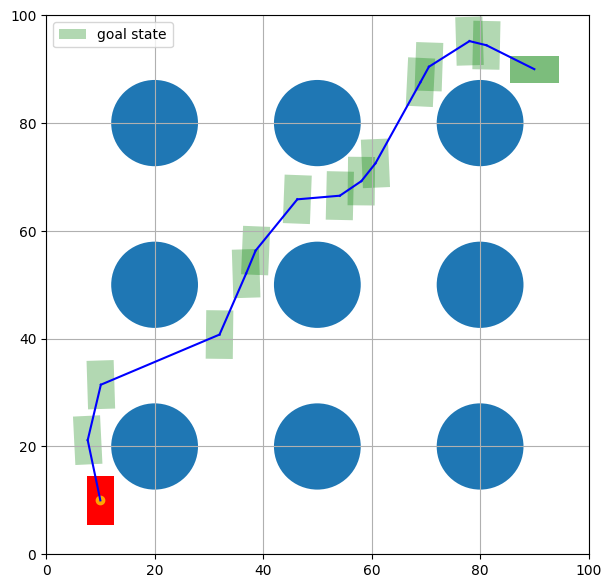

In [56]:
# col_checks = lazy_prm_star.build_roadmap(start_state, goal_state)

lazy_prm_star.render(path)    #, title=f"Lazy-PRM*-SIMPLE ENV": cost={compute_path_cost(path):.3f}\n collision checks={col_checks}

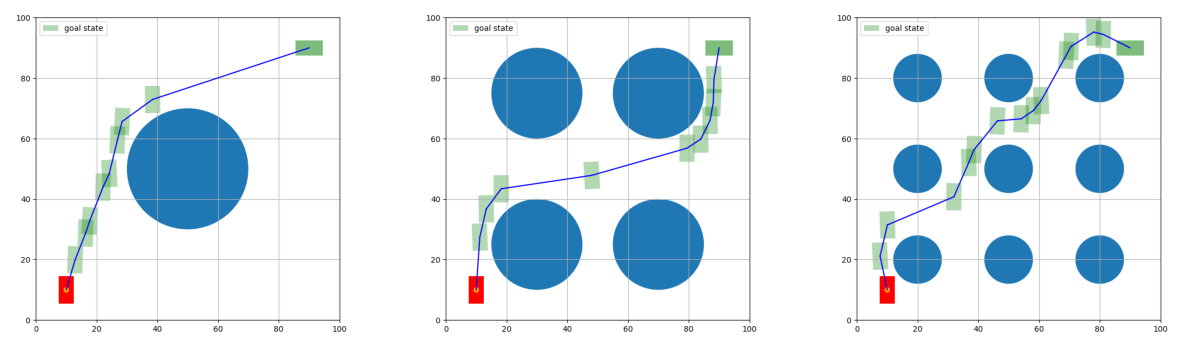

In [58]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the images
img1 = mpimg.imread('lazy_prm1.png')
img2 = mpimg.imread('lazy_prm4.png')
img3 = mpimg.imread('lazy_prm9.png')

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the images as subplots
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].axis('off')


axes[2].imshow(img3)
axes[2].axis('off')

# Display the subplots
plt.show()
